### 1.Introduction

In this project we were required to select a dataset and perfrom analysis on it to answer and explore various questions that we could come up with. The Titanic dataset was selected which presents the features of a sample of passengers on the Titanic such as their sex, age, embarkment port, fare and many others. After looking over the dataset, I found the following questions interesting :-

1) What sex had the better survival rate ?

2) Did people who paid more fare have a better survival rate ?

3) Did travelling alone or travelling with a family impact one's survival rate ?


### Organising the Report

This project will be using a Jupyter Notebook to describe the analysis performed on the Titanic dataset. Importing the necessary modules for performing the analysis below.

In [2]:
#Importing the required modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
from numbers import Number
from scipy import stats

#Allow plots and visualisations to be displayed in the report
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def as_a_percent(val, precision='0.2'):
    """Convert number to percentage string"""
    if isinstance(val, Number):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percentage = np.divide(val, total, dtype=float)
    if format_percent:
        percentage = as_a_percent(percentage)
    return percentage

### Reading the CSV as a DataFrame

In [4]:
#Reading the csv and storing it in a variable
titanic_file = 'D:/Data Analysis/Investigate a Dataset/titanic_data.csv'
titanic_df = pd.read_csv(titanic_file)

### Data Wrangling / Cleaning

In [5]:
#Printing out the information in the dataset
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We can observe from the above information about the dataset that a few of the columns have missing entries. Especially the 'Cabin' column has a significant number of missing entries. We won't be dealing with the 'Cabin' column however we will need to update the missing entries from the 'Age' and 'Embarked' columns to answer the questions we thought of above. 

### Replacing the Missing Ages 

In [6]:
#We will replace the missing entries in the age column by the mean of age based on Sex and Parch
missing_age_entries = titanic_df[titanic_df['Age'].isnull()]

mean_age = titanic_df.groupby(['Sex','Parch'])['Age'].mean()

#Function to replace the missing entries with the mean of age calculated above

def replace_missing_age_entries(mage) :
    if pd.isnull(mage['Age']):
        return mean_age[mage['Sex'], mage['Parch']]
    else :
        return mage['Age']
    
titanic_df['Age'] =titanic_df.apply(replace_missing_age_entries, axis=1)

### Investigating the Missing Embarked Ports
To update this column, we must first find out if the missing emabarkments were travelling with other passengers.

In [7]:
missing_embarked_ports = titanic_df[titanic_df['Embarked'].isnull()]
missing_embarked_ports

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We notice that both the passengers had the same ticket and cabin number, so we may assume that both were travelling in the same cabin with the same ticket. Since most of the passengers were from Southampton, we will consider the missing entries value to be Southampton.

In [8]:
titanic_df['Embarked'].fillna('S',inplace=True)

### Removing Unwanted Columns
We will be deleting the Name,Cabin and Ticket columns since we won't be needing them for our analysis. This will also speed up the dataframe processing. 

In [9]:
#Deleting Cabin,Name and Ticket columns
titanic_df = titanic_df.drop(['Cabin','Name','Ticket'], axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


### Mapping the Data

To make the data more concise and easier to interpret, we will modify the following fields in our updated dataset :

 1) Survived - changed to boolean (1 = True, 0 = False)

 2) Pclass - changed to Economic status (1st - First Class, 2nd - Second Class, 3rd - Third Class)

 3) Embarked - changed to name of embarkation port (C = Cherbourg; Q = Queenstown; S = Southampton)
 
We will combine the 'SibSp' and 'Parch' columns to help us better analyse the third question. 

In [10]:
#This function will return a mapped dataframe

def mapped_data(df):
    
    # survived map
    survivor_map = {0: False, 1: True}
    df['Survived'] = df['Survived'].map(survivor_map)

    # PClass map
    pclass_map = {1: 'First Class', 2: 'Second Class', 3: 'Third Class'}
    df['Pclass'] = df['Pclass'].map(pclass_map)

    # Embarkation port map
    ports_map = {'S': 'Southampton', 'C': 'Cherbourg','Q':'Queenstown'}
    df['Embarked'] = df['Embarked'].map(ports_map)
    
    # add new column (FamilyMembers) to dataframe - sum of SibSp and Parch
    df['FamilyMembers'] = df['SibSp'] + df['Parch']
    
    return df

titanic_df = mapped_data(titanic_df)
titanic_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembers
0,1,False,Third Class,male,22.0,1,0,7.2500,Southampton,1
1,2,True,First Class,female,38.0,1,0,71.2833,Cherbourg,1
2,3,True,Third Class,female,26.0,0,0,7.9250,Southampton,0
3,4,True,First Class,female,35.0,1,0,53.1000,Southampton,1
4,5,False,Third Class,male,35.0,0,0,8.0500,Southampton,0



### Analysing the Updated Dataset

Before exploring the answers to our questions, let us first find out the number of survivors since all of our questions deal with the survival rate. 

In [11]:
#Number of Survivors in our sample dataset

passengers = len(titanic_df)
survivors = len(titanic_df[titanic_df.Survived == True])
non_survivors = passengers - survivors

survivors_data = titanic_df[titanic_df.Survived==True]

non_survivors_data = titanic_df[titanic_df.Survived==False]

survivors = [
    ['Item','Sample Dataset (Count)', 'Sample Dataset (%)'],
    ['Total Passengers',passengers,'-'],
    ['Survivors', 
         survivors,
         calculate_percentage(survivors,passengers, True) 
    ],
    ['Non-survivors',  
         non_survivors,
         calculate_percentage(non_survivors,passengers, True) 
    ]
]


tbl.make_table(survivors)

Item,Sample Dataset (Count),Sample Dataset (%)
Total Passengers,891,-
Survivors,342,38.38%
Non-survivors,549,61.62%


### What sex had the better survival rate ?
Let us first find out the number of males and females present on board and then subsequently answer this question. We shall consider the hypothesis presented below :

    Hypotheis :
    
    Null Hypothesis (H0) - Survival rate is not affected by the Sex of the passenger
  
    Alternative Hypothesis (Ha) - Survival rate is affected by the Sex of the passenger
    
    

#### Number of Survivors by Sex

In [12]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['Sex'])
print table

Sex       female  male
Survived              
False         81   468
True         233   109


#### Proportion of Survivors by Sex

In [13]:
print titanic_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


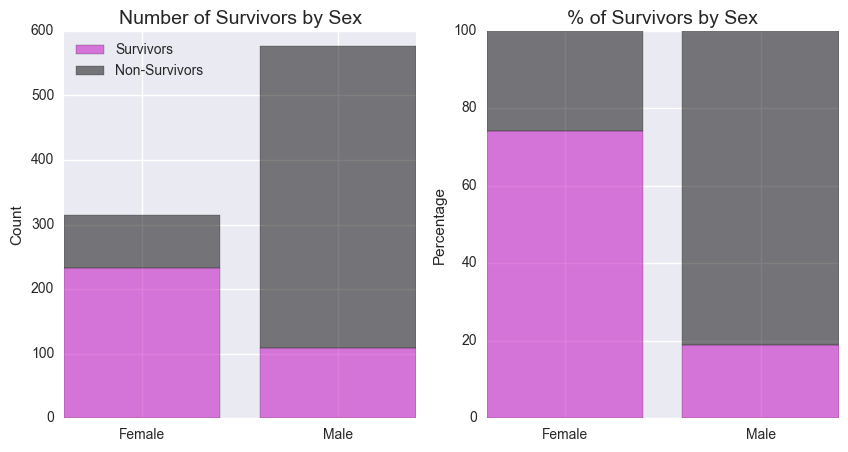

In [14]:
# calculate values for each survival status

survivors_sex = survivors_data.groupby(['Sex']).size().values
non_survivors_sex = non_survivors_data.groupby(['Sex']).size().values

# calculate the total for calculating percentages

totals = survivors_sex + non_survivors_sex

# use calculate_percentage_function to calculate percentage of the total

survivor_percentages = calculate_percentage(survivors_sex, totals)*100 
non_survivor_percentages = calculate_percentage(non_survivors_sex, totals)*100 

sex_categories = ['Female', 'Male']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# plot chart for count of survivors by sex

ax1.bar(range(len(survivors_sex)), survivors_sex, label='Survivors', alpha=0.5, color='m')
ax1.bar(range(len(non_survivors_sex)), non_survivors_sex, bottom=survivors_sex, label='Non-Survivors', alpha=0.5, color='k')
plt.sca(ax1)
plt.xticks([0.4, 1.4], sex_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Number of Survivors by Sex",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by sex
ax2.bar(range(len(survivor_percentages)), survivor_percentages, alpha=0.5, color='m')
ax2.bar(range(len(non_survivor_percentages)), non_survivor_percentages, bottom=survivor_percentages, alpha=0.5, color='k')
plt.sca(ax2)
plt.xticks([0.4, 1.4],  sex_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of Survivors by Sex",fontsize=14)

From the plots we can see that there were a significantly more number of males on board the Titanic than females. Observing both the plots we can see that the percentage of females survivors was more. Thus, we can safely say that the chance of survival was more if you were a female. To test our hypothesis, let us perform a Chi-Squared Test. 

In [15]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Sex'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


We see that the P-value is less than 0.005, so the probability that being a male or female affects the survival rate is high. As a result, with the help of the plots and the Chi-Squared Test, we can reject our null hypothesis. 

### Did belonging to any particular Pclass affect the survival rate ?
 Let us consider the hypothesis below to answer this question :
 
 Null Hypothesis(H0) - The economic class has no effect on the survival rate
 
 Alternative Hypothesis (Ha) - Belonging to a particular class significantly increases the survival rate.


#### Number of Survivors by Class

In [16]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['Pclass'])
print table

Pclass    First Class  Second Class  Third Class
Survived                                        
False              80            97          372
True              136            87          119


#### Proportion of Survivors by Class

In [17]:
print titanic_df.groupby('Pclass').Survived.mean()

Pclass
First Class     0.629630
Second Class    0.472826
Third Class     0.242363
Name: Survived, dtype: float64


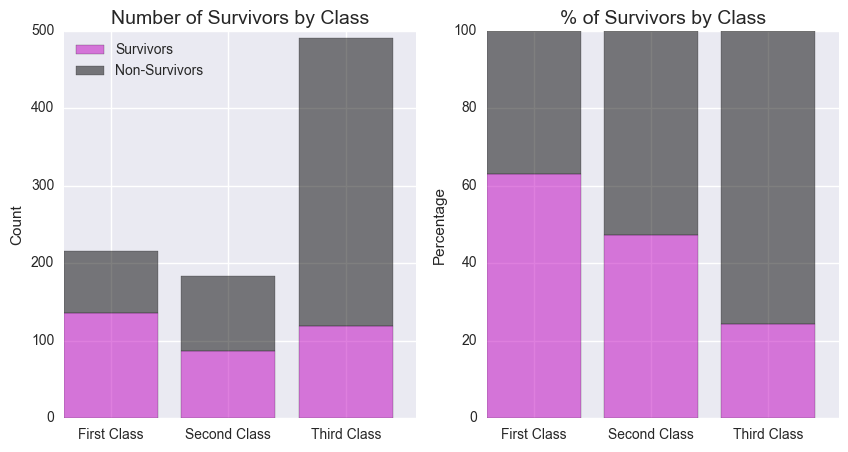

In [18]:
# calculate values for each survival status

survivors_class = survivors_data.groupby(['Pclass']).size().values
non_survivors_class = non_survivors_data.groupby(['Pclass']).size().values

# calculate the total for calculating percentages

totals = survivors_class + non_survivors_class

# use calculate_percentage_function to calculate percentage of the total

survivor_percentages = calculate_percentage(survivors_class, totals)*100 
non_survivor_percentages = calculate_percentage(non_survivors_class, totals)*100 

class_categories = ['First Class', 'Second Class', 'Third Class']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# plot chart for count of survivors by class

ax1.bar(range(len(survivors_class)), survivors_class, label='Survivors', alpha=0.5, color='m')
ax1.bar(range(len(non_survivors_class)), non_survivors_class, bottom=survivors_class, label='Non-Survivors', alpha=0.5, color='k')
plt.sca(ax1)
plt.xticks([0.4, 1.4, 2.4], class_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Number of Survivors by Class",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by class
ax2.bar(range(len(survivor_percentages)), survivor_percentages, alpha=0.5, color='m')
ax2.bar(range(len(non_survivor_percentages)), non_survivor_percentages, bottom=survivor_percentages, alpha=0.5, color='k')
plt.sca(ax2)
plt.xticks([0.4, 1.4, 2.4],  class_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of Survivors by Class",fontsize=14)

We can see from the plots that though there were more number of passengers in the Third class, it had the lowest survival rate. The Second Class was in the middle of both the First Class and the Third Class with respect to the number of passengers. The First class as observed above had the highest survival rate. Let us a perform a Chi-Squared Test to test our hypothesis. 

In [19]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Pclass'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


We see that the P-value is less than 0.005, so the probability that belonging to a particular class affects the survival rate is high. So we reject our null hypothesis and can safely say that belonging to a particular class did affect the survival rate and the chances of survival were the highest if you belonged to the First Class.

###  Did travelling alone or travelling with a family impact one's survival rate ?
 Let us consider the hypothesis below to answer our question :
 
 Null Hypothesis (H0)- Travelling alone or travelling with family does not impact the survival rate.
 
 Alternative Hypothesis (Ha) - Travelling alone or with family significantly affect the survival rate.

#### Number of Survivors by Family Members

In [20]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['FamilyMembers'])
print table

FamilyMembers   0   1   2   3   4   5   6   7   10
Survived                                          
False          374  72  43   8  12  19   8   6   7
True           163  89  59  21   3   3   4   0   0


#### Proportion of Survivors by Family Members

In [21]:
print titanic_df.groupby('FamilyMembers').Survived.mean()

FamilyMembers
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64


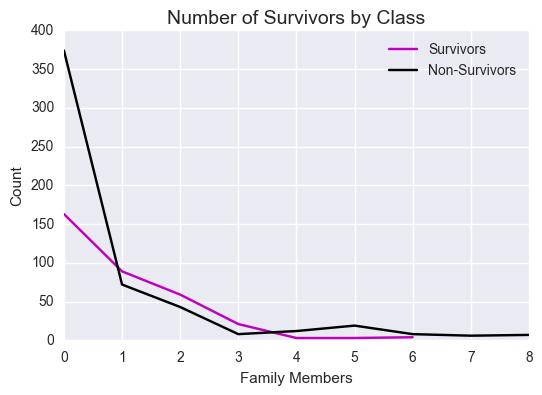

In [33]:
survivors_family = survivors_data.groupby(['FamilyMembers']).size().values

non_survivors_family = non_survivors_data.groupby(['FamilyMembers']).size().values

# calculate the total for calculating percentages

totals = len(titanic_df['FamilyMembers'])

# use calculate_percentage_function to calculate percentage of the total

survivor_percentages = calculate_percentage(survivors_class, totals)*100 
non_survivor_percentages = calculate_percentage(non_survivors_class, totals)*100

plt.plot(survivors_family,color='m', label='Survivors')
plt.plot(non_survivors_family,color='k',label='Non-Survivors' )
plt.ylabel('Count')
plt.xlabel('Family Members');
plt.title("Number of Survivors by Class",fontsize=14)
plt.legend(loc='upper right')

From the plots and the calculations above we can see that a person had more chance of survival if he was travelling with someone. Let us perform a Chi-Squared Test to confirm our obsevations.

In [110]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['FamilyMembers'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,80.6723
P-Value,0.0000


As the P-value is less than 0.005, the probability that travelling with someone affects the survival rate is high.This confirms our observations and hence we reject our hypothesis.

### Conclusion
We should note that we performed data analysis only on a sample of the complete data and a lot of information was missing too. Availability of missing data and size of the complete dataset may have skewed the results. As with any dataset, the more information we have, the better it can be analysed. Information such as number of lifeboats could have significantly helped us figure out why there were so many casualties on board the the Titanic. One more interesting fact to take a note of is that we don't know if this dataset we are using was a random sample or not. It could be biased or unbiased too. The size of this sample as a results could also have impacted the results we have obtained.

In [36]:
print missing_age_entries.groupby('Sex').size()

Sex
female     53
male      124
dtype: int64


There are 53 missing ages for female and 124 missing ages for male which for a sample of 891 could be considered significant. There are various methods by which we could handle this missing data. Below we discuss a possible few of such methods :-

1) If we want to actually increase the accuracy for analysis of the Age factor in this dataset, we could simply delete all the missing ages from the dataset. However, inversely this would confine the accuracy for analysis of Sex and Class. 

2) The other option which we have implemented in this project is to replace the missing ages by generating ages based on the mean of the ages. This could however skew the results for our analysis of age. 

# References

1) http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
2) http://www.anesi.com/titanic.htm
3) http://cs229.stanford.edu/proj2012/LamTang-TitanicMachineLearningFromDisaster.pdf
4) https://blog.dataiku.com/2014/05/12/getting-started-data-science-titanic-kaggle-part-1